<h2>Introduction and loading data</h2>

There are two sets of data in this 'kernels only' competition: News and Prices/Returns. The ideia is to use both sets to predict the movement of a given financial asset in the next 10 days. We have data from 2007 to 2017 for training and must predict the movement of assets from Jan 2017 to July 2019.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['marketdata_sample.csv', 'news_sample.csv']


In [2]:
# load data from twosigma
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()
(marketdf, newsdf) = env.get_training_data()

Loading the data... This could take a minute.
Done!


In [3]:
import lightgbm as lgb
from datetime import datetime, date
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [4]:
marketdf.head().T

0            ...                                      4
time                      2007-02-01 22:00:00+00:00            ...              2007-02-01 22:00:00+00:00
assetCode                                       A.N            ...                                  ABB.N
assetName                  Agilent Technologies Inc            ...                                ABB Ltd
volume                                   2.6069e+06            ...                             1.2086e+06
close                                         32.19            ...                                  18.02
open                                          32.17            ...                                  18.01
returnsClosePrevRaw1                      0.0059375            ...                              0.0117911
returnsOpenPrevRaw1                       0.0053125            ...                              0.0250427
returnsClosePrevMktres1                         NaN            ...                                    NaN
returnsOpenPrevMktres1                          NaN            ...                                    NaN
returnsClosePrevRaw10                   -0.00186047            ...                              0.0129286
returnsOpenPrevRaw10                    0.000622084            ...                              0.0203966
returnsClosePrevMktres10                        NaN            ...                                    NaN
returnsOpenPrevMktres10                         NaN            ...                                    NaN
returnsOpenNextMktres10                    0.034672            ...                             -0.0179941
universe                                          1            ...                                      1

[16 rows x 5 columns]

In [5]:
newsdf.head().T

0                        ...                                                                          4
time                                          2007-01-01 04:29:32+00:00                        ...                                                  2007-01-01 12:08:37+00:00
sourceTimestamp                               2007-01-01 04:29:32+00:00                        ...                                                  2007-01-01 12:08:37+00:00
firstCreated                                  2007-01-01 04:29:32+00:00                        ...                                                  2007-01-01 12:08:37+00:00
sourceId                                               e58c6279551b85cf                        ...                                                           23768af19dc69992
headline              China's Daqing pumps 43.41 mln tonnes of oil i...                        ...                                      PRESS DIGEST - New York Times - Jan 1
urgency                                                               3                        ...                                                                          3
takeSequence                                                          1                        ...                                                                          1
provider                                                           RTRS                        ...                                                                       RTRS
subjects              {'ENR', 'ASIA', 'CN', 'NGS', 'EMRG', 'RTRS', '...                        ...                          {'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...
audiences                                             {'Z', 'O', 'OIL'}                        ...                          {'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...
bodySize                                                           1438                        ...                                                                       1776
companyCount                                                          1                        ...                                                                          6
headlineTag                                                                                    ...                                                               PRESS DIGEST
marketCommentary                                                  False                        ...                                                                      False
sentenceCount                                                        11                        ...                                                                         14
wordCount                                                           275                        ...                                                                        325
assetCodes                    {'0857.HK', '0857.F', '0857.DE', 'PTR.N'}                        ...                                                                 {'XMSR.O'}
assetName                                             PetroChina Co Ltd                        ...                                            XM Satellite Radio Holdings Inc
firstMentionSentence                                                  6                        ...                                                                         11
relevance                                                      0.235702                        ...                                                                   0.149071
sentimentClass                                                       -1                        ...                                                                         -1
sentimentNegative                                              0.500739                        ...                                                                   0.699274
sentimentNeutral                                               0.419

<h2>Exploratory Data Analysis (EDA) on Market data and News data</h2>

## Market data
We can see long-term trends, appearing and declining companies and many other things.

At first let's take 10 random assets and plot them.

In [6]:
data = []
for asset in np.random.choice(marketdf['assetName'].unique(), 10):
    asset_df = marketdf[(marketdf['assetName'] == asset)]

    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
layout = go.Layout(dict(title = "Closing prices of 10 random assets",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

It would be more interesting to see general trends of prices.

In [7]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = marketdf.groupby('time')['close'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of closing prices by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),
    annotations=[
        dict(
            x='2008-09-01 22:00:00+0000',
            y=82,
            xref='x',
            yref='y',
            text='Collapse of Lehman Brothers',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2011-08-01 22:00:00+0000',
            y=85,
            xref='x',
            yref='y',
            text='Black Monday',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2014-10-01 22:00:00+0000',
            y=120,
            xref='x',
            yref='y',
            text='Another crisis',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=-20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2016-01-01 22:00:00+0000',
            y=120,
            xref='x',
            yref='y',
            text='Oil prices crash',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        )
    ])
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [8]:
marketdf['price_diff'] = marketdf['close'] - marketdf['open']
grouped = marketdf.groupby('time').agg({'price_diff': ['std', 'min']}).reset_index()

In [9]:
print(f"Average standard deviation of price change within a day in {grouped['price_diff']['std'].mean():.4f}.")

Average standard deviation of price change within a day in 1.0335.


In [11]:
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * g['price_diff']['min']).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

We can see huge price fluctiations when market crashed. But this is wrong... There was no huge crash on January 2010... Let's dive into the data.

### Possible data errors

At first let's simply sort data by the difference between open and close prices.

In [12]:
marketdf.sort_values('price_diff')[:10]

time assetCode     ...     universe  price_diff
1127598 2010-01-04 22:00:00+00:00      TW.N     ...          0.0  -9948.9900
627547  2008-09-29 22:00:00+00:00      BK.N     ...          1.0  -3261.6136
502997  2008-06-05 22:00:00+00:00     AHG.N     ...          0.0   -982.7000
471381  2008-05-06 22:00:00+00:00    CEPH.O     ...          1.0   -938.9500
242847  2007-09-27 22:00:00+00:00     EXH.N     ...          1.0   -920.0000
3264631 2015-03-16 22:00:00+00:00    TECD.O     ...          0.0   -207.2100
7273    2007-02-08 22:00:00+00:00      BA.N     ...          1.0   -110.4800
375899  2008-02-06 22:00:00+00:00     CME.N     ...          1.0    -98.2400
628075  2008-09-29 22:00:00+00:00     IBM.N     ...          1.0    -77.5200
3565205 2015-11-20 22:00:00+00:00     CMG.N     ...          0.0    -75.8100

[10 rows x 17 columns]

So, let's try to find strange cases.

In [13]:
marketdf['close_to_open'] =  np.abs(marketdf['close'] / marketdf['open'])

In [14]:
print(f"In {(marketdf['close_to_open'] >= 1.2).sum()} lines price increased by 20% or more.")
print(f"In {(marketdf['close_to_open'] <= 0.8).sum()} lines price decreased by 20% or more.")

In 1211 lines price increased by 20% or more.
In 778 lines price decreased by 20% or more.


Well, this isn't much considering we have more than 4 million lines and a lot of these cases are due to price falls during market crash. Well just need to deal with outliers.

In [15]:
print(f"In {(marketdf['close_to_open'] >= 2).sum()} lines price increased by 100% or more.")
print(f"In {(marketdf['close_to_open'] <= 0.5).sum()} lines price decreased by 100% or more.")

In 38 lines price increased by 100% or more.
In 16 lines price decreased by 100% or more.


For a quick fix I'll replace outliers in these lines with mean open or close price of this company.

In [16]:
marketdf['assetName_mean_open'] = marketdf.groupby('assetName')['open'].transform('mean')
marketdf['assetName_mean_close'] = marketdf.groupby('assetName')['close'].transform('mean')

# if open price is too far from mean open price for this company, replace it. Otherwise replace close price.
for i, row in marketdf.loc[marketdf['close_to_open'] >= 2].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        marketdf.iloc[i,5] = row['assetName_mean_open']
    else:
        marketdf.iloc[i,4] = row['assetName_mean_close']
        
for i, row in marketdf.loc[marketdf['close_to_open'] <= 0.5].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        marketdf.iloc[i,5] = row['assetName_mean_open']
    else:
        marketdf.iloc[i,4] = row['assetName_mean_close']

In [17]:
marketdf['price_diff'] = marketdf['close'] - marketdf['open']
grouped = marketdf.groupby(['time']).agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * np.round(g['price_diff']['min'], 2)).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values * 5,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Now the graph is much more reasonable.

In [18]:
data = []
for i in [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = marketdf.groupby('time')['returnsOpenNextMktres10'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of returnsOpenNextMktres10 by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

### Let's see some trends of additional features like MACD, Z score, MA, EMA...

In [19]:
marketdf['close_to_open'] = marketdf['close'] / marketdf['open']
# DIF-MACD
ma_12 = lambda x: x.rolling(12).mean()
ma_26 = lambda x: x.rolling(26).mean()
marketdf['DIF'] = marketdf.groupby('assetCode')['close'].transform(lambda x : pd.Series.ewm(x, span=12).mean())-marketdf.groupby('assetCode')['close'].transform(lambda x : pd.Series.ewm(x, span=26).mean())
marketdf['MACD'] = marketdf['DIF'].transform(lambda x : pd.Series.ewm(x, span=9).mean())
marketdf['OSC'] = marketdf['DIF']-marketdf['MACD']
# Z score: 200, 20
zscore_fun_improved = lambda x:(x - x.rolling(window=15, min_periods=7).mean())/x.rolling(window=15, min_periods=7).std()
marketdf['zscore'] = marketdf.groupby('assetCode')['close'].apply(zscore_fun_improved)
marketdf['average'] = (marketdf['close'] + marketdf['open'])/2
marketdf['price_volume'] = marketdf['volume'] * marketdf['close']
marketdf['volume_to_mean'] = marketdf['volume'] / marketdf['volume'].mean()
# time series rolling based features: mean, std, ewm
windows = [7,14]
#f = ['open','close','returnsOpenPrevMktres10', 'returnsClosePrevMktres10']
f = ['returnsOpenPrevMktres10']
for ff in f:
    for d in windows:
        marketdf['%s_%s_mean'%(ff,d)] = marketdf.groupby('assetCode')[ff].apply(lambda x: x.rolling(d).mean())
        #marketdf['%s_%s_std'%(ff,d)] = marketdf.groupby('assetCode')[ff].apply(lambda x: x.rolling(d).std())
        marketdf['%s_%s_ewm'%(ff,d)] = marketdf.groupby('assetCode')[ff].transform(lambda x : pd.Series.ewm(x, span=d).mean())

In [20]:
marketdf.head().T

0            ...                                      4
time                             2007-02-01 22:00:00+00:00            ...              2007-02-01 22:00:00+00:00
assetCode                                              A.N            ...                                  ABB.N
assetName                         Agilent Technologies Inc            ...                                ABB Ltd
volume                                          2.6069e+06            ...                             1.2086e+06
close                                                32.19            ...                                  18.02
open                                                 32.17            ...                                  18.01
returnsClosePrevRaw1                             0.0059375            ...                              0.0117911
returnsOpenPrevRaw1                              0.0053125            ...                              0.0250427
returnsClosePrevMktres1                                NaN            ...                                    NaN
returnsOpenPrevMktres1                                 NaN            ...                                    NaN
returnsClosePrevRaw10                          -0.00186047            ...                              0.0129286
returnsOpenPrevRaw10                           0.000622084            ...                              0.0203966
returnsClosePrevMktres10                               NaN            ...                                    NaN
returnsOpenPrevMktres10                                NaN            ...                                    NaN
returnsOpenNextMktres10                           0.034672            ...                             -0.0179941
universe                                                 1            ...                                      1
price_diff                                            0.02            ...                                   0.01
close_to_open                                      1.00062            ...                                1.00056
assetName_mean_open                                38.5882            ...                                21.0333
assetName_mean_close                               38.6072            ...                                 21.039
DIF                                                      0            ...                                      0
MACD                                                     0            ...                                      0
OSC                                                      0            ...                                      0
zscore                                                 NaN            ...                                    NaN
average                                              32.18            ...                                 18.015
price_volume                                   8.39161e+07            ...                             2.1779e+07
volume_to_mean                                    0.978084            ...                               0.453455
returnsOpenPrevMktres10_7_mean                         NaN            ...                                    NaN
returnsOpenPrevMktres10_7_ewm                          NaN            ...                                    NaN
returnsOpenPrevMktres10_14_mean                        NaN            ...                                    NaN
returnsOpenPrevMktres10_14_ewm                         NaN            ...                                    NaN

[31 rows x 5 columns]

We can see that quantiles have a high deviation, but mean value doesn't change much.

Now I think it is time to throw an old part of dataset. Let's leave only data since 2010 year, this way we will get rid of the data of the biggest crisis.

In [21]:
data = []
marketdf = marketdf.loc[marketdf['assetCode'] == 'AAPL.O']
marketdf = marketdf.loc[marketdf['time'] >= '2014-01-01 22:00:00+0000']
features = ['close']
for f in features:
    price_df = marketdf.groupby('time')[f].mean().reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df[f].values,
        name = f'%s'%f
    ))
layout = go.Layout(dict(title = "Treand of z-score of Apple.Inc",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Let's have a look at means of the return variables.

In [22]:
data = []
for col in ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10']:
    df = marketdf.groupby('time')[col].mean().reset_index()
    data.append(go.Scatter(
        x = df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df[col].values,
        name = col
    ))
    
layout = go.Layout(dict(title = "Treand of mean values",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

See some correlation between prices.

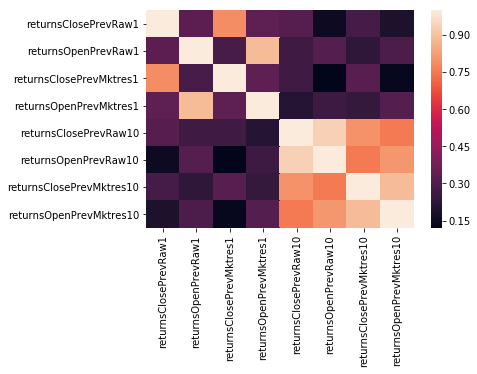

In [25]:
from sklearn.preprocessing import scale

df = marketdf.groupby('time')['returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10'].mean().reset_index()
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### EDA on News data

In [26]:
print(f'{newsdf.shape[0]} samples and {newsdf.shape[1]} features in the training news dataset.')

9328750 samples and 35 features in the training news dataset.


The file is too huge to work with text directly, so let's see a wordcloud of the last 100000 headlines.

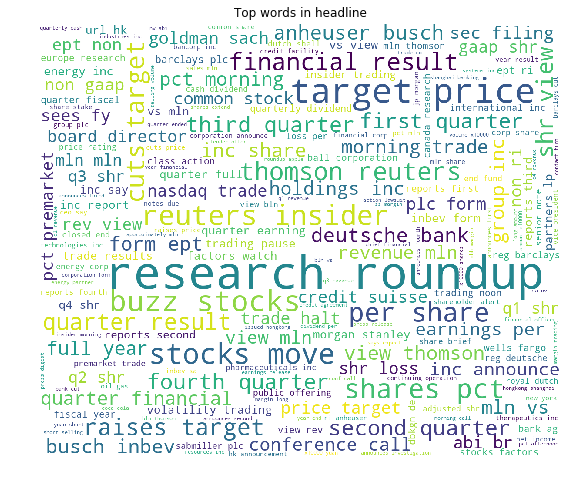

In [27]:
text = ' '.join(newsdf['headline'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

In [28]:
# Let's also limit the time period
newsdf = newsdf.loc[newsdf['time'] >= '2010-01-01 22:00:00+0000']

In [29]:
news_train_df = newsdf

In [30]:
# Sort values by time then extract date
news_train_df = news_train_df.sort_values(by='time')
news_train_df['date'] = news_train_df['time'].dt.date

In [31]:
# Function to plot time series data
def plot_vs_time(data_frame, column, calculation='mean', span=10):
    if calculation == 'mean':
        group_temp = data_frame.groupby('date')[column].mean().reset_index()
    if calculation == 'count':
        group_temp = data_frame.groupby('date')[column].count().reset_index()
    if calculation == 'nunique':
        group_temp = data_frame.groupby('date')[column].nunique().reset_index()
    group_temp = group_temp.ewm(span=span).mean()
    fig = plt.figure(figsize=(10,3))
    plt.plot(group_temp['date'], group_temp[column])
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.title('%s versus time' %column)

Text(0,0.5,'Count')

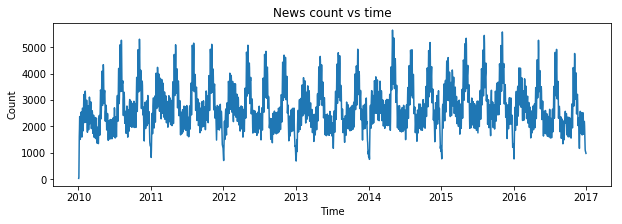

In [32]:
plot_vs_time(news_train_df, 'sourceId', calculation='count', span=10)
plt.title('News count vs time')
plt.ylabel('Count')

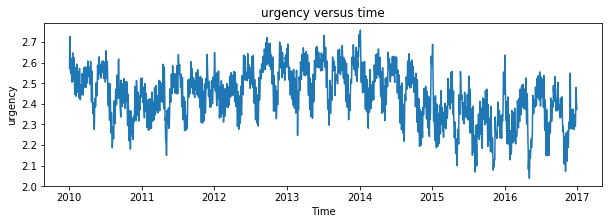

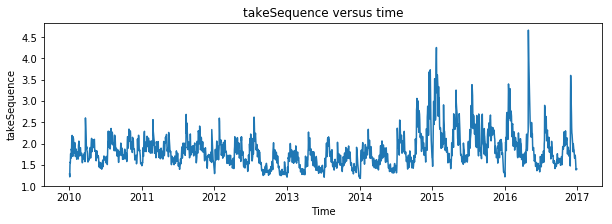

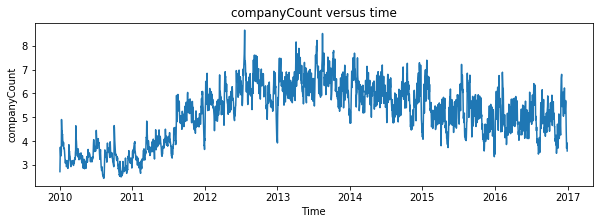

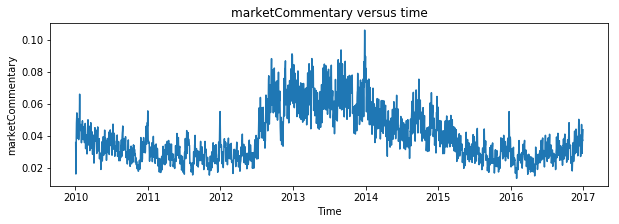

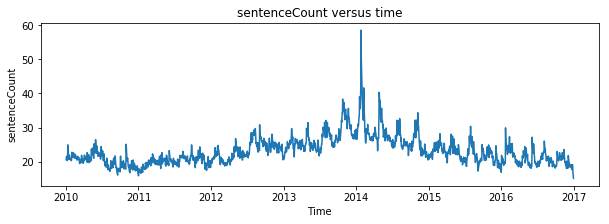

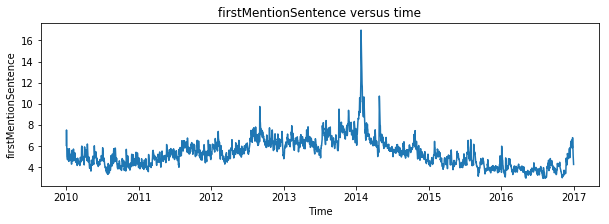

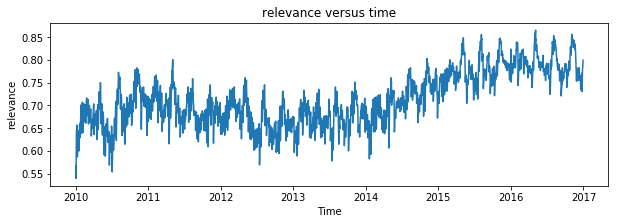

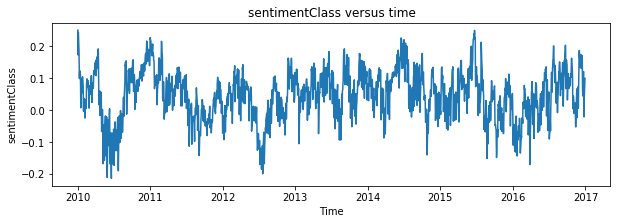

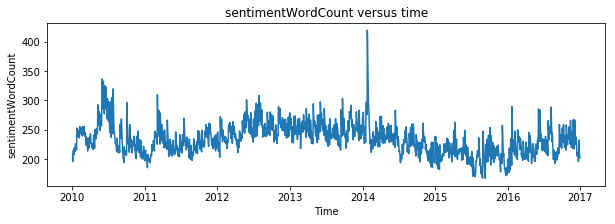

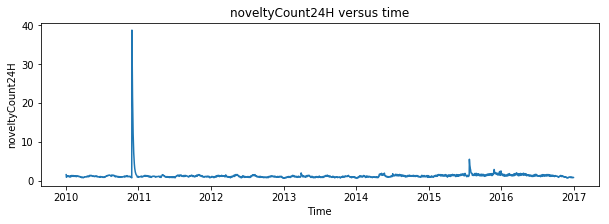

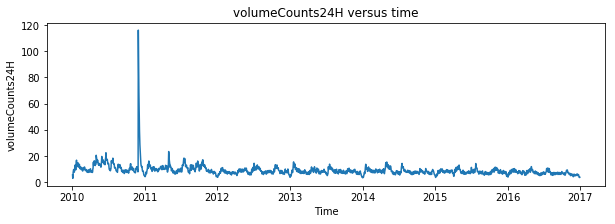

In [33]:
# Plot time evolution of several parameters

columns = ['urgency', 'takeSequence', 'companyCount','marketCommentary','sentenceCount',\
           'firstMentionSentence','relevance','sentimentClass','sentimentWordCount','noveltyCount24H', 'volumeCounts24H']

for column in columns:
    plot_vs_time(news_train_df, column)

In [34]:
time_delay = (pd.to_datetime(news_train_df['time']) - pd.to_datetime(news_train_df['firstCreated']))
time_delay_log10 = np.log10(time_delay.dt.total_seconds()/60+1)

Text(0.5,1,'Delay time distribution')

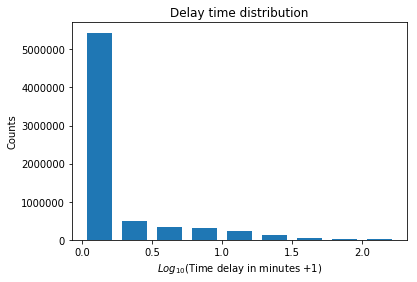

In [35]:
plt.hist(time_delay_log10, bins=np.arange(0,2.5,0.25), rwidth=0.7)
plt.xlabel('$Log_{10}$(Time delay in minutes +1)')
plt.ylabel('Counts')
plt.title('Delay time distribution')

Text(0,0.5,'Delay (minutes)')

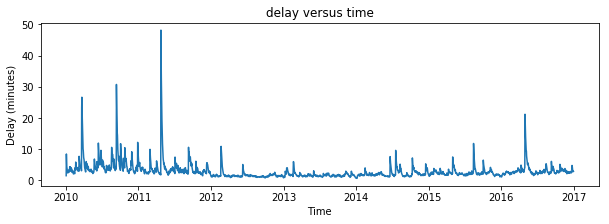

In [36]:
time_delay_min = time_delay.dt.total_seconds()/60
time_delay_df = time_delay_min.to_frame().join(news_train_df['date'].to_frame())
time_delay_df.columns = ['delay','date']
plot_vs_time(time_delay_df, 'delay')
plt.ylabel('Delay (minutes)')

In [37]:
urgency_count = news_train_df.groupby('urgency')['sourceId'].count()
urgency_count = urgency_count/urgency_count.sum()
print('Urgency ratio')
urgency_count.sort_values(ascending=True)

Urgency ratio


urgency
2    0.000004
1    0.363768
3    0.636229
Name: sourceId, dtype: float64

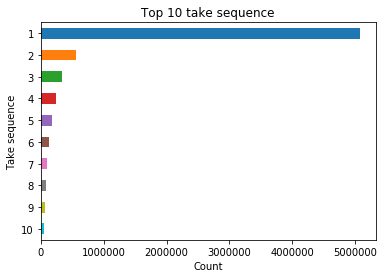

In [38]:
take_sequence = news_train_df.groupby('takeSequence')['sourceId'].count()
take_sequence = take_sequence.sort_values(ascending= False)
take_sequence[:10].plot.barh()
plt.xlabel('Count')
plt.ylabel('Take sequence')
plt.title('Top 10 take sequence')
plt.gca().invert_yaxis()
del take_sequence

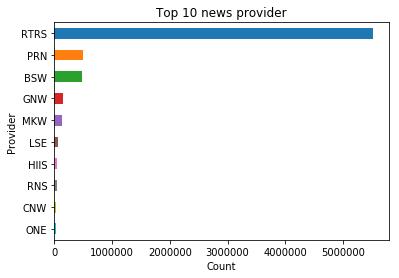

In [39]:
provider_count = news_train_df.groupby('provider')['sourceId'].count()
provider_sort = provider_count.sort_values(ascending= False)
provider_sort[:10].plot.barh()
plt.xlabel('Count')
plt.ylabel('Provider')
plt.title('Top 10 news provider')
plt.gca().invert_yaxis()
del provider_count

In [42]:
import re
# Extract data from a single cell
def contents_to_list(contents):
    text = contents[1:-1]
    text = re.sub(r",",' ',text)
    text = re.sub(r"'","", text)
    text_list = text.split('  ')
    return text_list

# Put data from columns into dict
def get_content_dict(content_column):
    content_dict = {}
    for i in range(len(content_column)):
        this_cell = content_column[i]
        content_list = contents_to_list(this_cell)        
        for content in content_list:
            if content in content_dict.keys():
                content_dict[content] += 1
            else:
                content_dict[content] = 1
    return content_dict

In [43]:
subjects = news_train_df.sample(n=10000, random_state=1)['subjects']
subjects_dict = get_content_dict(subjects)

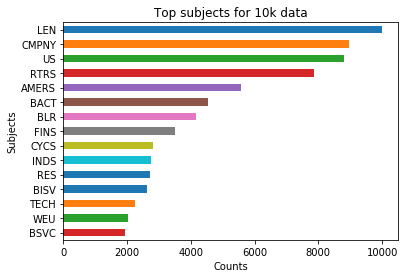

In [44]:
subjects_df = pd.Series(subjects_dict).sort_values(ascending=False)
subjects_df[:15].plot.barh()
plt.ylabel('Subjects')
plt.xlabel('Counts')
plt.title('Top subjects for 10k data')
plt.gca().invert_yaxis()
del subjects_df

In [45]:
audiences = news_train_df.sample(n=10000, random_state=1)['audiences']
audiences_dict = get_content_dict(audiences)

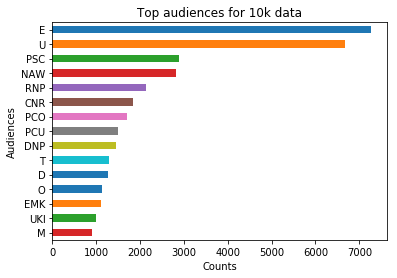

In [46]:
audiences_df = pd.Series(audiences_dict).sort_values(ascending=False)
audiences_df[:15].plot.barh()
plt.ylabel('Audiences')
plt.xlabel('Counts')
plt.title('Top audiences for 10k data')
plt.gca().invert_yaxis()

Text(0.5,1,'Company count distribution')

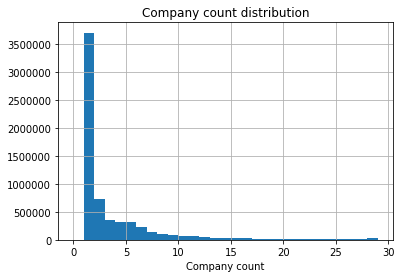

In [47]:
news_train_df['companyCount'].hist(bins=np.arange(0,30,1))
plt.xlabel('Company count')
plt.title('Company count distribution')

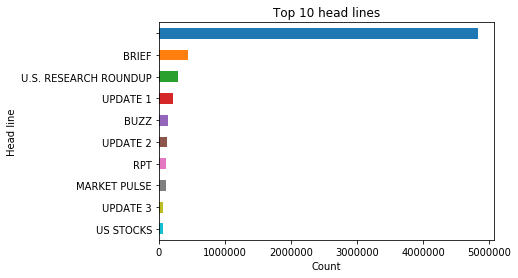

In [48]:
head_line = news_train_df.groupby('headlineTag')['sourceId'].count()
head_line_sort = head_line.sort_values(ascending= False)
head_line_sort[:10].plot.barh()
plt.xlabel('Count')
plt.ylabel('Head line')
plt.title('Top 10 head lines')
plt.gca().invert_yaxis()
del head_line

Text(0.5,1,'First mention sentence distribution')

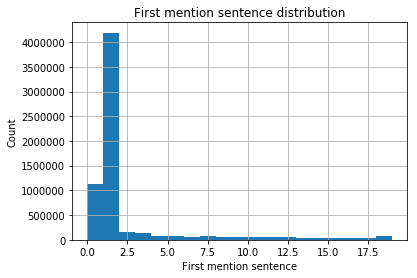

In [49]:
news_train_df['firstMentionSentence'].hist(bins=np.arange(0,20,1))
plt.xlabel('First mention sentence')
plt.ylabel('Count')
plt.title('First mention sentence distribution')

In [50]:
sentence_urgency = news_train_df.groupby('firstMentionSentence')['urgency'].mean()
sentence_urgency.head(5)
del sentence_urgency

Text(0.5,1,'Relevance distribution')

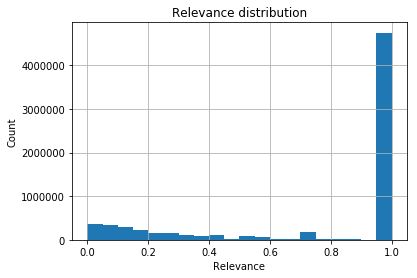

In [51]:
news_train_df['relevance'].hist(bins=np.arange(0,1.01,0.05))
plt.xlabel('Relevance')
plt.ylabel('Count')
plt.title('Relevance distribution')

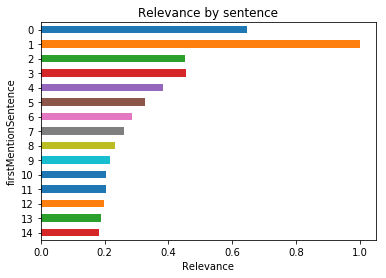

In [52]:
sentence_relevance = news_train_df.groupby('firstMentionSentence')['relevance'].mean()
sentence_relevance[:15].plot.barh()
plt.xlabel('Relevance')
plt.title('Relevance by sentence')
plt.gca().invert_yaxis()
del sentence_relevance

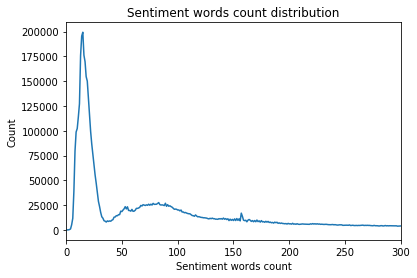

In [53]:
sentimentWordCount = news_train_df.groupby('sentimentWordCount')['sourceId'].count().reset_index()
plt.plot(sentimentWordCount['sentimentWordCount'], sentimentWordCount['sourceId'])
plt.xlim(0,300)
plt.xlabel('Sentiment words count')
plt.ylabel('Count')
plt.title('Sentiment words count distribution')
del sentimentWordCount

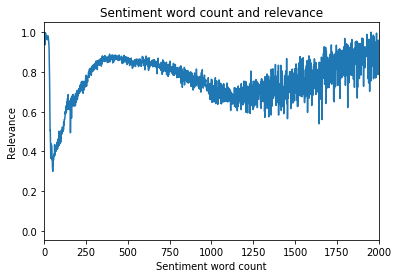

In [54]:
sentimentWordRatio = news_train_df.groupby('sentimentWordCount')['relevance'].mean()
plt.plot(sentimentWordRatio)
plt.xlim(0,2000)
plt.ylabel('Relevance')
plt.xlabel('Sentiment word count')
plt.title('Sentiment word count and relevance')
del sentimentWordRatio

Text(0.5,1,'Sentiment ratio distribution')

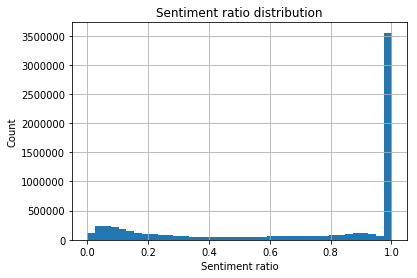

In [55]:
news_train_df['sentimentRatio'] = news_train_df['sentimentWordCount']/news_train_df['wordCount']
news_train_df['sentimentRatio'].hist(bins=np.linspace(0,1.001,40))
plt.xlabel('Sentiment ratio')
plt.ylabel('Count')
plt.title('Sentiment ratio distribution')

Text(0.5,1,'Relevance vs sentiment ratio of 10k samples')

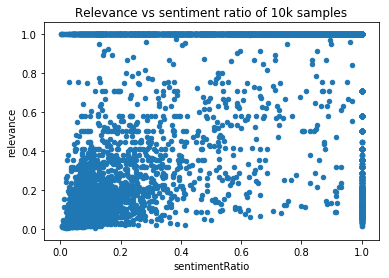

In [56]:
news_train_df.sample(n=10000, random_state=1).plot.scatter('sentimentRatio', 'relevance')
plt.title('Relevance vs sentiment ratio of 10k samples')

In [57]:
asset_name = news_train_df.groupby('assetName')['sourceId'].count()
print('Total number of assets: ',news_train_df['assetName'].nunique())

Total number of assets:  7845


Text(0.5,1,'Top 10 assets news')

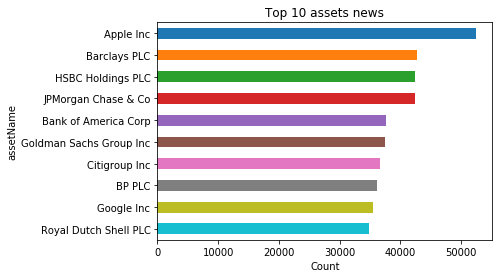

In [58]:
asset_name = asset_name.sort_values(ascending=False)
asset_name[:10].plot.barh()
plt.gca().invert_yaxis()
plt.xlabel('Count')
plt.title('Top 10 assets news')

In [59]:
for i, j in zip([-1, 0, 1], ['negative', 'neutral', 'positive']):
    df_sentiment = news_train_df.loc[news_train_df['sentimentClass'] == i, 'assetName']
    print(f'Top mentioned companies for {j} sentiment are:')
    print(df_sentiment.value_counts().head(5))
    print('')

Top mentioned companies for negative sentiment are:
Apple Inc                  22518
JPMorgan Chase & Co        20647
BP PLC                     19328
Goldman Sachs Group Inc    17955
Bank of America Corp       17704
Name: assetName, dtype: int64

Top mentioned companies for neutral sentiment are:
HSBC Holdings PLC    19462
Credit Suisse AG     14632
Deutsche Bank AG     12959
Barclays PLC         12414
Apple Inc            10994
Name: assetName, dtype: int64

Top mentioned companies for positive sentiment are:
Apple Inc                19020
Barclays PLC             18051
Royal Dutch Shell PLC    15484
General Electric Co      14163
Boeing Co                14080
Name: assetName, dtype: int64



In [60]:
# Function to remove outliers
def remove_outliers(data_frame, column_list, low=0.02, high=0.98):
    temp_frame = data_frame
    for column in column_list:
        this_column = data_frame[column]
        quant_df = this_column.quantile([low,high])
        low_limit = quant_df[low]
        high_limit = quant_df[high]
        temp_frame[column] = data_frame[column].clip(lower=low_limit, upper=high_limit)
    return temp_frame

In [61]:
# Remove outlier
columns_outlier = ['takeSequence', 'bodySize', 'sentenceCount', 'wordCount', 'sentimentWordCount', 'firstMentionSentence','noveltyCount12H',\
                  'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H', 'volumeCounts24H',\
                  'volumeCounts3D','volumeCounts5D','volumeCounts7D']
news_rmv_outlier = remove_outliers(news_train_df, columns_outlier)

Text(0.5,1,'Pair-wise correlation')

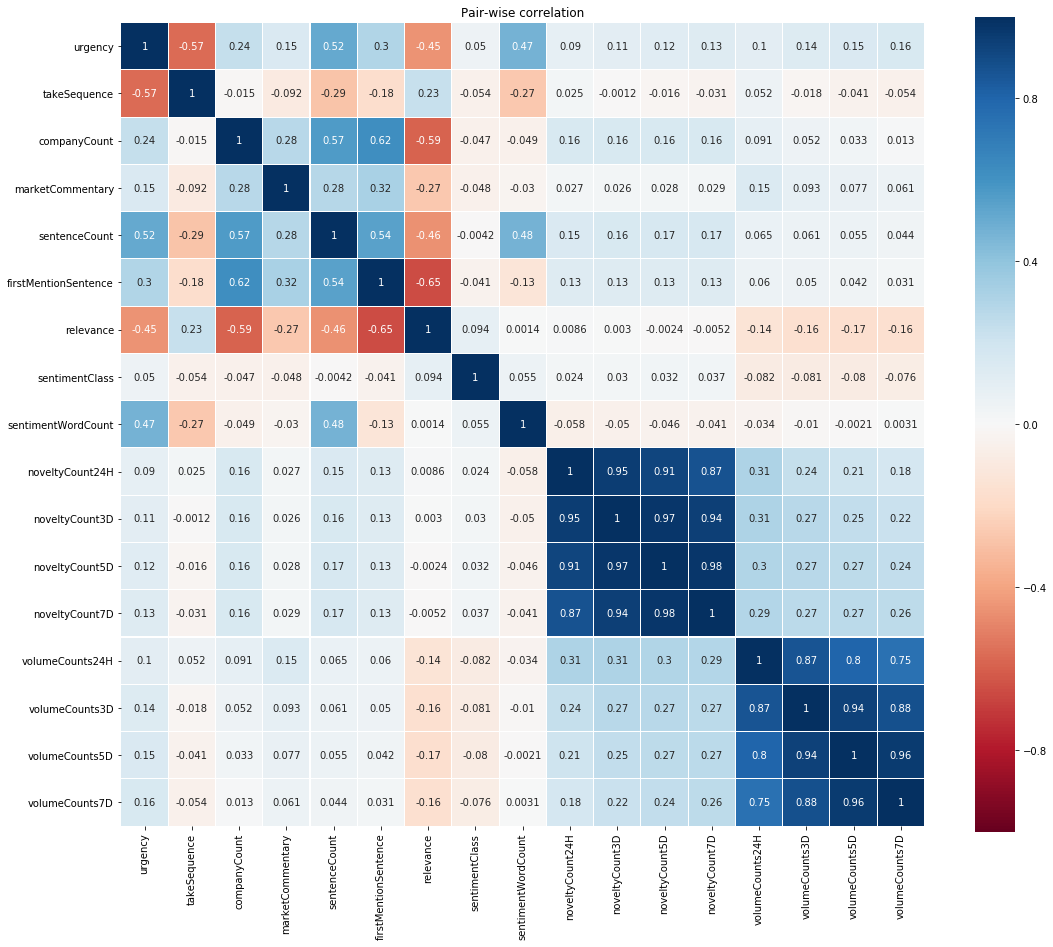

In [62]:
# Plot correlation
columns_corr = ['urgency', 'takeSequence', 'companyCount','marketCommentary','sentenceCount',\
           'firstMentionSentence','relevance','sentimentClass','sentimentWordCount','noveltyCount24H',\
           'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D','volumeCounts24H','volumeCounts3D','volumeCounts5D','volumeCounts7D']
colormap = plt.cm.RdBu
plt.figure(figsize=(18,15))
sns.heatmap(news_rmv_outlier[columns_corr].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True)
plt.title('Pair-wise correlation')